### Flow Matching Ergodic Coverage using Heat Kernel
#### 2D coverage using heat kernel with the second-order point-mass dynamics

This tutorial uses [`lqrax`](https://github.com/MaxMSun/lqrax/tree/main) to solve the continuous time Riccati equation for the LQ flow matching problem and uses heat kernel smoothed gradient vector to guide the agents.

#### Parameters

**diffusion_coefficient**: diffusion coefficient for the heat kernel control the global/local coverage trade-off. Increasing the diffusion coefficient leads to more global coverage. Another interpretation is that increasing it results in larger agent footprint decreasing the diffusion coefficient requires more iterations to fully cover the target.


In [1]:
# Parameters 
# ==============================================================================
step_size = 0.0001
num_iters = 200
diffusion_coefficient = 2e-3 

# Parameter set (global coverage)
# ==============================================================================
# step_size = 1
# num_iters = 200
# diffusion_coefficient = 1e-2

# Parameter set (local coverage)
# ==============================================================================
# step_size = 5
# num_iters = 1000
# diffusion_coefficient = 5e-4

In [2]:
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import jax.numpy as jnp
import os
import numpy as np

from jax import jit, grad, vmap, jacfwd
from jax.scipy.stats import gaussian_kde as kde
from jax.scipy.stats import multivariate_normal as mvn
import jax
cpu = jax.devices("cpu")[0]
try:
    gpu = jax.devices("cuda")[0]
except:
    gpu = cpu
jnp.set_printoptions(precision=4)

try:
    from lqrax import LQR
except:
    %pip install lqrax
    from lqrax import LQR


In [3]:
import urllib.request

object_list = [
    'airplane', 'eifeltower', 'fire', 'heart', 'lock', 'scissors', 'star', 'sword', 'thunder', 'trophy'
]
obj_idx = 5

object = object_list[obj_idx]
print(f'object: {object}')

resp = urllib.request.urlopen(
    f"https://raw.githubusercontent.com/MurpheyLab/lqr-flow-matching/refs/heads/main/tutorials/test_objects/2d/{object}.txt")
tgt_samples = np.loadtxt(f"./test_objects/2d/{object}.txt")[:, :2]

tgt_samples = jnp.array(tgt_samples)

num_samples = tgt_samples.shape[0]
print(f'samples.shape: {tgt_samples.shape}')

object: scissors
samples.shape: (1500, 2)


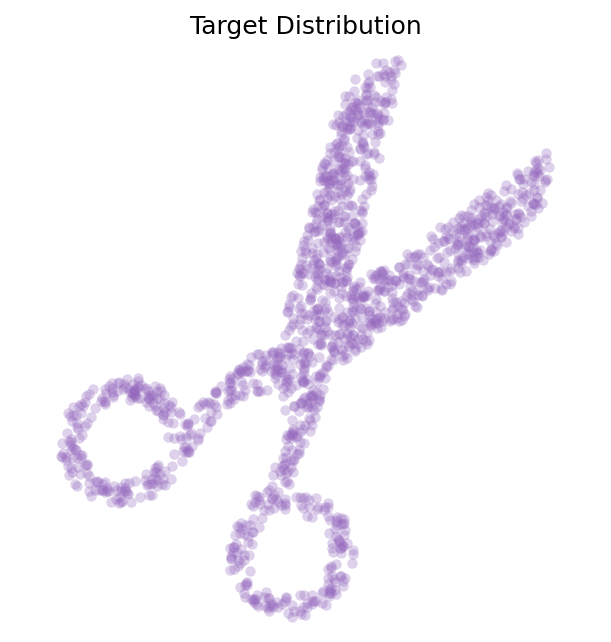

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 6), dpi=150)
ax.set_title("Target Distribution")
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_aspect('equal')
ax.axis('off')
ax.plot(tgt_samples[:, 0], tgt_samples[:, 1], linestyle='', marker='o',
        markersize=5, markeredgecolor='none', color='C4', alpha=0.3)
plt.show()
plt.close()

In [ ]:
# Heat kernel replacing the Sinkhron Divergence
# ==============================================================================
def heat_kernel(x, y, diffusion_coefficient):
    """
    Note that  Gaussian kernel is the heat kernel in Euclidean domains.
    Compute Gaussian kernel matrix between x and y. 
    """
    x_norm = jnp.sum(x**2, axis=1, keepdims=True)
    y_norm = jnp.sum(y**2, axis=1, keepdims=True)
    dists = x_norm - 2 * x @ y.T + y_norm.T
    return jnp.exp(-dists / (4 * diffusion_coefficient))


@jax.jit
def compute_heat_kernel_dx_traj(x_samples, tgt_samples, diffusion_coefficient=1e-3):
    """
    Compute gradient directions using heat kernel similarity
    """
    # Heat kernels
    K_xt = heat_kernel(x_samples, tgt_samples, diffusion_coefficient)
    K_xx = heat_kernel(x_samples, x_samples, diffusion_coefficient)

    # Row normalization
    K_xt /= jnp.sum(K_xt, axis=1, keepdims=True)
    K_xx /= jnp.sum(K_xx, axis=1, keepdims=True)

    # Displacement vectors
    delta_xt = tgt_samples[None, :, :] - x_samples[:, None, :]
    delta_xx = x_samples[None, :, :] - x_samples[:, None, :]

    # Weighted displacements
    grad_xt = jnp.sum(K_xt[:, :, None] * delta_xt, axis=1)
    grad_xx = jnp.sum(K_xx[:, :, None] * delta_xx, axis=1)

    alpha = 0.5
    return alpha * grad_xt - (1 - alpha) * grad_xx

In [6]:
dt = 0.05
tsteps = 200
T = dt * tsteps

_x0 = tgt_samples[0]
x0 = jnp.array([
    _x0[0],
    _x0[1],
    2.0 * (0.5-_x0[0]) / T,
    2.0 * (0.5-_x0[1]) / T,
])
u_traj = jnp.zeros((tsteps, 2))

In [7]:
class PointMassLQR(LQR):
    def __init__(self, dt, x_dim, u_dim, Q, R):
        super().__init__(dt, x_dim, u_dim, Q, R)

    def dyn(self, xt, ut):
        return jnp.array([xt[2], xt[3], ut[0], ut[1]])

In [8]:
Q = jnp.diag(jnp.array([1.0, 1.0, 0.001, 0.001]))
R = jnp.diag(jnp.array([0.01, 0.01]))
pointmass_lqr = PointMassLQR(dt=dt, x_dim=4, u_dim=2, Q=Q, R=R)

# lqr solving on CPU is faster
linearize_dyn = jit(pointmass_lqr.linearize_dyn, device=cpu)
solve_lqr = jit(pointmass_lqr.solve, device=cpu)

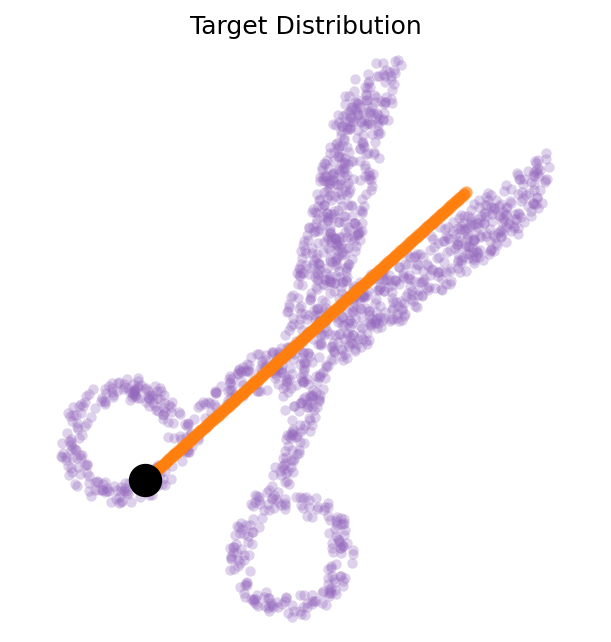

In [9]:
x_traj = pointmass_lqr.traj_sim(x0, u_traj)

fig, ax = plt.subplots(1, 1, figsize=(5, 6), dpi=150)
ax.set_title("Target Distribution")
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_aspect('equal')
ax.axis('off')
ax.plot(tgt_samples[:, 0], tgt_samples[:, 1], linestyle='', marker='o',
        markersize=5, markeredgecolor='none', color='C4', alpha=0.3)
ax.plot(x_traj[:, 0], x_traj[:, 1], linestyle='-', linewidth=3,
        marker='o', markersize=5, color='C1', alpha=0.5)
ax.plot(x0[0], x0[1], linestyle='', marker='o', markersize=15, color='k')
plt.show()
plt.close()

heat_kernel_dx_traj .shape: (200, 2) == x_traj.shape: (200, 4)


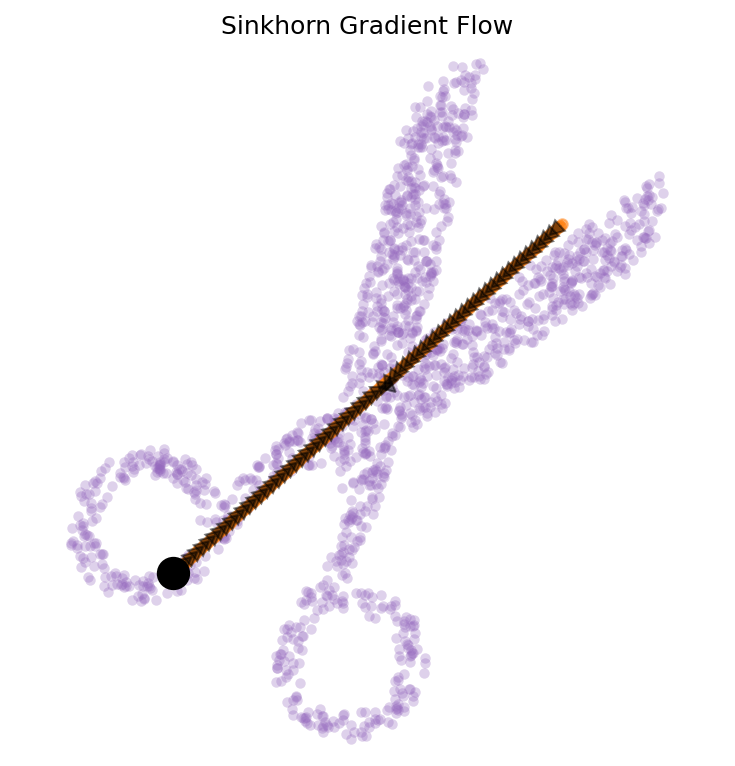

In [10]:
heat_kernel_dx_traj = step_size* compute_heat_kernel_dx_traj(x_traj[:,:2],tgt_samples[:,:2])
heat_kernel_dx_traj = np.array(heat_kernel_dx_traj)
# note that the dimension of the descent direction matches the trajectory
print(
    f'heat_kernel_dx_traj .shape: {heat_kernel_dx_traj.shape} == x_traj.shape: {x_traj.shape}')

fig, ax = plt.subplots(1, 1, figsize=(5, 6), dpi=150, tight_layout=True)
ax.set_title('Sinkhorn Gradient Flow')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_aspect('equal')
ax.axis('off')
ax.plot(tgt_samples[:, 0], tgt_samples[:, 1], linestyle='', marker='o',
        markersize=5, markeredgecolor='none', color='C4', alpha=0.3)
ax.plot(x_traj[:, 0], x_traj[:, 1], linestyle='-', linewidth=3,
        marker='o', markersize=5, color='C1', alpha=0.5)
for t in range(len(x_traj[::3])):
    vis_scale = 1
    ax.arrow(
        x_traj[::3][t, 0], x_traj[::3][t, 1],
        vis_scale * step_size* heat_kernel_dx_traj[::3][t, 0],
        vis_scale * step_size* heat_kernel_dx_traj[::3][t, 1],
        width=0.002,
        head_width=0.02,
        head_length=0.02,
        alpha=0.5,
        color='k',
        zorder=2
    )
ax.plot(x0[0], x0[1], linestyle='', marker='o', markersize=15, color='k')
plt.show()
plt.close()

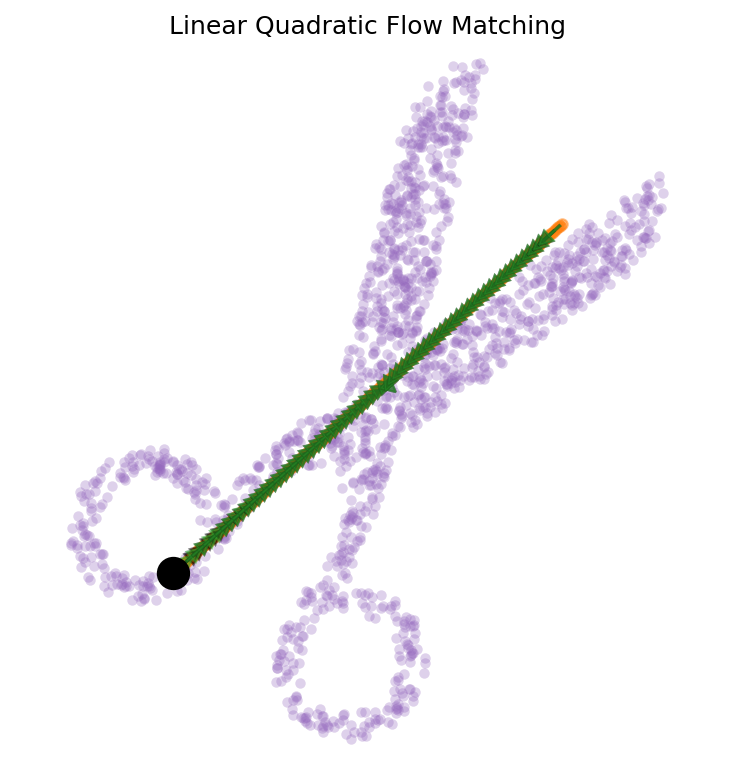

In [11]:
# Solve the LQ flow matching problem for current iteration
x_traj, A_traj, B_traj = linearize_dyn(x0, u_traj)
z0 = jnp.zeros(4)
# Concatenate zeros to the heat kernel dx trajectory
# ==============================================================================
zeros = np.zeros((heat_kernel_dx_traj.shape[0], 2))
heat_kernel_dx_traj = np.hstack((heat_kernel_dx_traj, zeros))
v_traj, z_traj = solve_lqr(z0, A_traj, B_traj, heat_kernel_dx_traj)


fig, ax = plt.subplots(1, 1, figsize=(5, 6), dpi=150, tight_layout=True)
ax.set_title('Linear Quadratic Flow Matching')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_aspect('equal')
ax.axis('off')
ax.plot(tgt_samples[:, 0], tgt_samples[:, 1], linestyle='', marker='o',
        markersize=5, markeredgecolor='none', color='C4', alpha=0.3)
ax.plot(x_traj[:, 0], x_traj[:, 1], linestyle='-', linewidth=3,
        marker='o', markersize=5, color='C1', alpha=0.5)
for t in range(len(x_traj[::3])):
    vis_scale = 1
    ax.arrow(
        x_traj[::3][t, 0], x_traj[::3][t, 1],
        vis_scale * heat_kernel_dx_traj[::3][t, 0],
        vis_scale * heat_kernel_dx_traj[::3][t, 1],
        width=0.002,
        head_width=0.02,
        head_length=0.02,
        alpha=0.5,
        color='k',
        zorder=2,
    )
    ax.arrow(
        x_traj[::3][t, 0], x_traj[::3][t, 1],
        vis_scale * z_traj[::3][t, 0],
        vis_scale * z_traj[::3][t, 1],
        width=0.002,
        head_width=0.02,
        head_length=0.02,
        alpha=0.5,
        color='C2',
        zorder=2
    )
ax.plot(x0[0], x0[1], linestyle='', marker='o', markersize=15, color='k')
plt.show()
plt.close()

  0%|          | 0/200 [00:00<?, ?it/s]

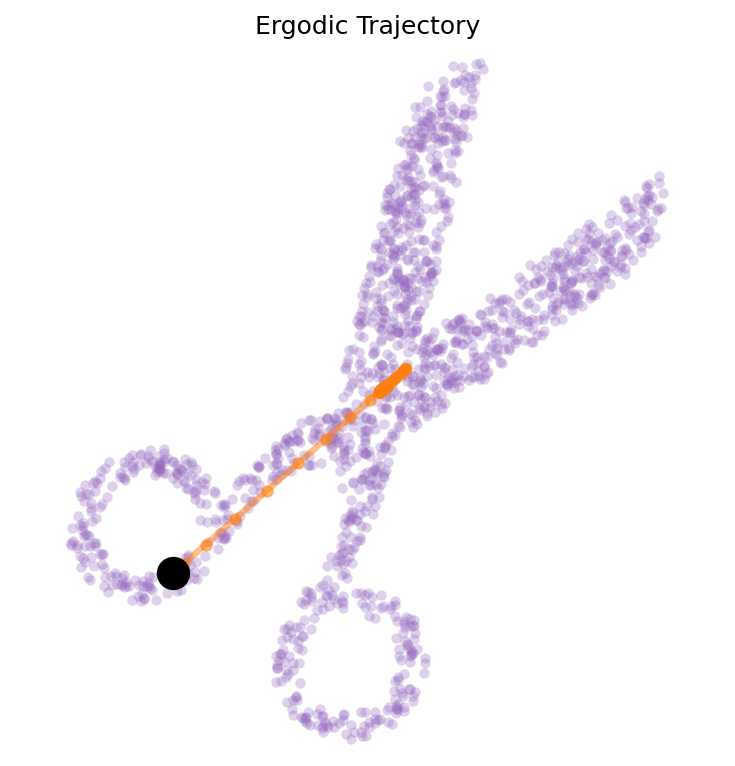

In [12]:
# Solve the flow matching ergodic coverage problem
z0 = jnp.zeros(4)
x_traj_list = []
for i in tqdm(range(num_iters)):
    x_traj, A_traj, B_traj = linearize_dyn(x0, u_traj)
    # Heat kernel dx trajectory
    # ==============================================================================
    heat_kernel_dx_traj = compute_heat_kernel_dx_traj(
        x_traj[:, :2], tgt_samples[:, :2], diffusion_coefficient=diffusion_coefficient
    )
    heat_kernel_dx_traj = np.array(heat_kernel_dx_traj)
    heat_kernel_dx_traj = np.hstack((heat_kernel_dx_traj, zeros))
    # ==============================================================================
    v_traj, z_traj = solve_lqr(z0, A_traj, B_traj, heat_kernel_dx_traj)
    u_traj += step_size * v_traj
    x_traj_list.append(np.array(x_traj))
final_x_traj = pointmass_lqr.traj_sim(x0, u_traj)
x_traj_list.append(final_x_traj)
x_traj_list = np.array(x_traj_list)

fig, ax = plt.subplots(1, 1, figsize=(5, 6), dpi=150, tight_layout=True)
ax.set_title("Ergodic Trajectory")
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_aspect("equal")
ax.axis("off")
ax.plot(
    tgt_samples[:, 0],
    tgt_samples[:, 1],
    linestyle="",
    marker="o",
    markersize=5,
    markeredgecolor="none",
    color="C4",
    alpha=0.3,
)
ax.plot(
    final_x_traj[:, 0],
    final_x_traj[:, 1],
    linestyle="-",
    linewidth=3,
    marker="o",
    markersize=5,
    color="C1",
    alpha=0.5,
)
ax.plot(x0[0], x0[1], linestyle="", marker="o", markersize=15, color="k")
plt.show()
plt.close()

In [13]:
import io
import base64
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# 1) Grab the Matplotlib "C1" color
traj_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]

# 2) Render the PDF contour to an in-memory PNG via Matplotlib
buf = io.BytesIO()
fig_mpl, ax = plt.subplots(figsize=(5, 5), dpi=150)
ax.plot(tgt_samples[:, 0], tgt_samples[:, 1], linestyle='', marker='o',
        markersize=5, markeredgecolor='none', color='C4', alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
fig_mpl.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
plt.close(fig_mpl)
img_uri = "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode()

# 3) Build the Plotly figure
fig = go.Figure()

# 3a) Static background image
fig.update_layout(
    images=[dict(
        source=img_uri,
        xref="x", yref="y",
        x=0, y=1,
        sizex=1, sizey=1,
        sizing="stretch",
        layer="below"
    )],
    margin=dict(l=10, r=10, t=30, b=60),
    plot_bgcolor="white",
    width=800,    # square canvas
    height=600
)

# 3b) Initial trajectory (trace 0) — so it's drawn below the start marker
traj0 = x_traj_list[-1]
fig.add_trace(go.Scatter(
    x=traj0[:, 0], y=traj0[:, 1],
    mode="lines+markers",
    line=dict(color=traj_color, width=3),
    marker=dict(size=10, opacity=0.6, color=traj_color),
    showlegend=False
))

# 3c) Static start marker (trace 1) — drawn on top
fig.add_trace(go.Scatter(
    x=[x0[0]], y=[x0[1]],
    mode="markers",
    marker=dict(size=20, color="black"),
    showlegend=False
))

# 4) Build frames: update only trace index 0 (the trajectory)
frames = []
for i, traj in enumerate(x_traj_list):
    frames.append(go.Frame(
        name=str(i),
        data=[go.Scatter(
            x=traj[:, 0], y=traj[:, 1],
            mode="lines+markers",
            line=dict(color=traj_color, width=5),
            marker=dict(size=10, opacity=0.6, color=traj_color)
        )],
        traces=[0]
    ))
fig.frames = frames

# 5) Slider (narrow, centered)
steps = [
    dict(method="animate",
         args=[[str(i)], dict(mode="immediate",
                              frame=dict(duration=0, redraw=True),
                              transition=dict(duration=0))],
         label=str(i))
    for i in range(len(x_traj_list))
]
fig.update_layout(
    sliders=[dict(
        active=num_iters,
        y=-0.05,
        x=0.5,
        xanchor="center",
        pad=dict(t=10),
        len=0.5,
        steps=steps,
        currentvalue=dict(prefix="Iteration: ", font=dict(size=12))
    )]
)

# 6) Start / Pause / Reset buttons (row, centered, moved down)
fig.update_layout(
    updatemenus=[dict(
        type="buttons",
        direction="left",
        x=0.5,
        y=-0.25,
        xanchor="center",
        yanchor="top",
        pad=dict(r=10, t=10),
        buttons=[
            dict(label="Start",
                 method="animate",
                 args=[None, dict(frame=dict(duration=30, redraw=True),
                                  transition=dict(duration=0),
                                  fromcurrent=True,
                                  mode="immediate")]),
            dict(label="Pause",
                 method="animate",
                 args=[[None], dict(frame=dict(duration=0, redraw=False),
                                    transition=dict(duration=0),
                                    mode="immediate")]),
            dict(label="Reset",
                 method="animate",
                 args=[[str(0)], dict(frame=dict(duration=0, redraw=True),
                                      transition=dict(duration=0),
                                      mode="immediate")])
        ]
    )]
)

# 7) Hide axes completely
fig.update_xaxes(visible=False, range=[0, 1], constrain="domain")
fig.update_yaxes(visible=False, range=[0, 1], scaleanchor="x")

fig.show()
# fig.write_html(
#     f"html/sinkhorn_{object}.html",
#     include_plotlyjs="cdn", 
#     full_html=True,
#     auto_play=False
# )